In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

# Normalization

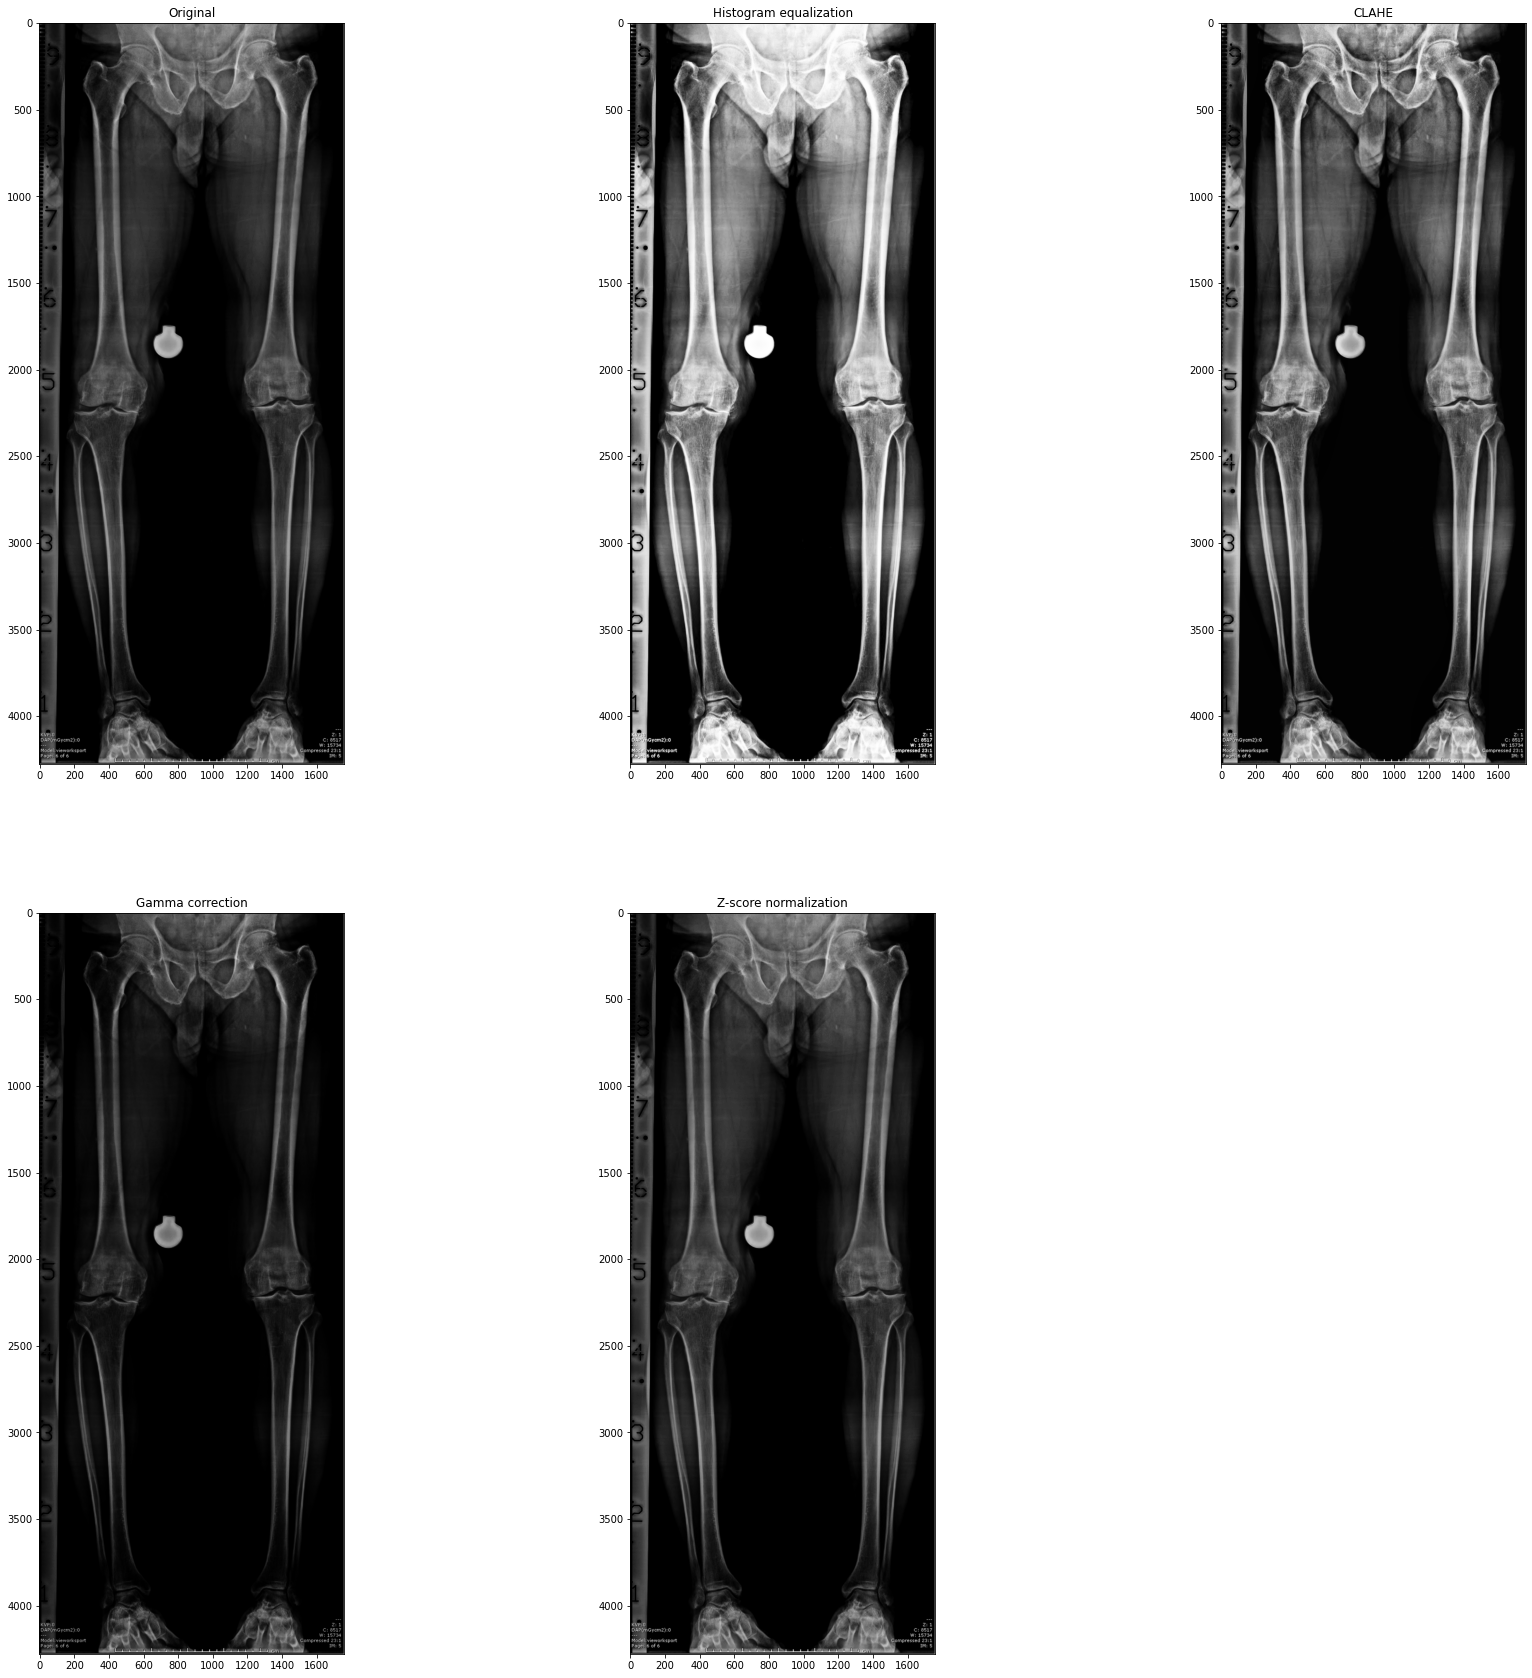

In [61]:
img = cv2.imread('../test_dark.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histogram equalization
equalized_img = cv2.equalizeHist(img)

# Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(img)

# Gamma correction
gamma = 1.5
gamma_corrected = np.uint8(cv2.pow(img/255.0, gamma) * 255.0)

# Z-score normalization
mean, std = cv2.meanStdDev(img)
z_score_normalized = (img - mean) / std

plt.figure(figsize=(30,30))
plt.subplot(2,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(equalized_img, cmap="gray")
plt.title("Histogram equalization")
plt.subplot(2,3,3)
plt.imshow(clahe_img, cmap="gray")
plt.title("CLAHE")
plt.subplot(2,3,4)
plt.imshow(gamma_corrected, cmap="gray")
plt.title("Gamma correction")
plt.subplot(2,3,5)
plt.title("Z-score normalization")
plt.imshow(z_score_normalized, cmap="gray")


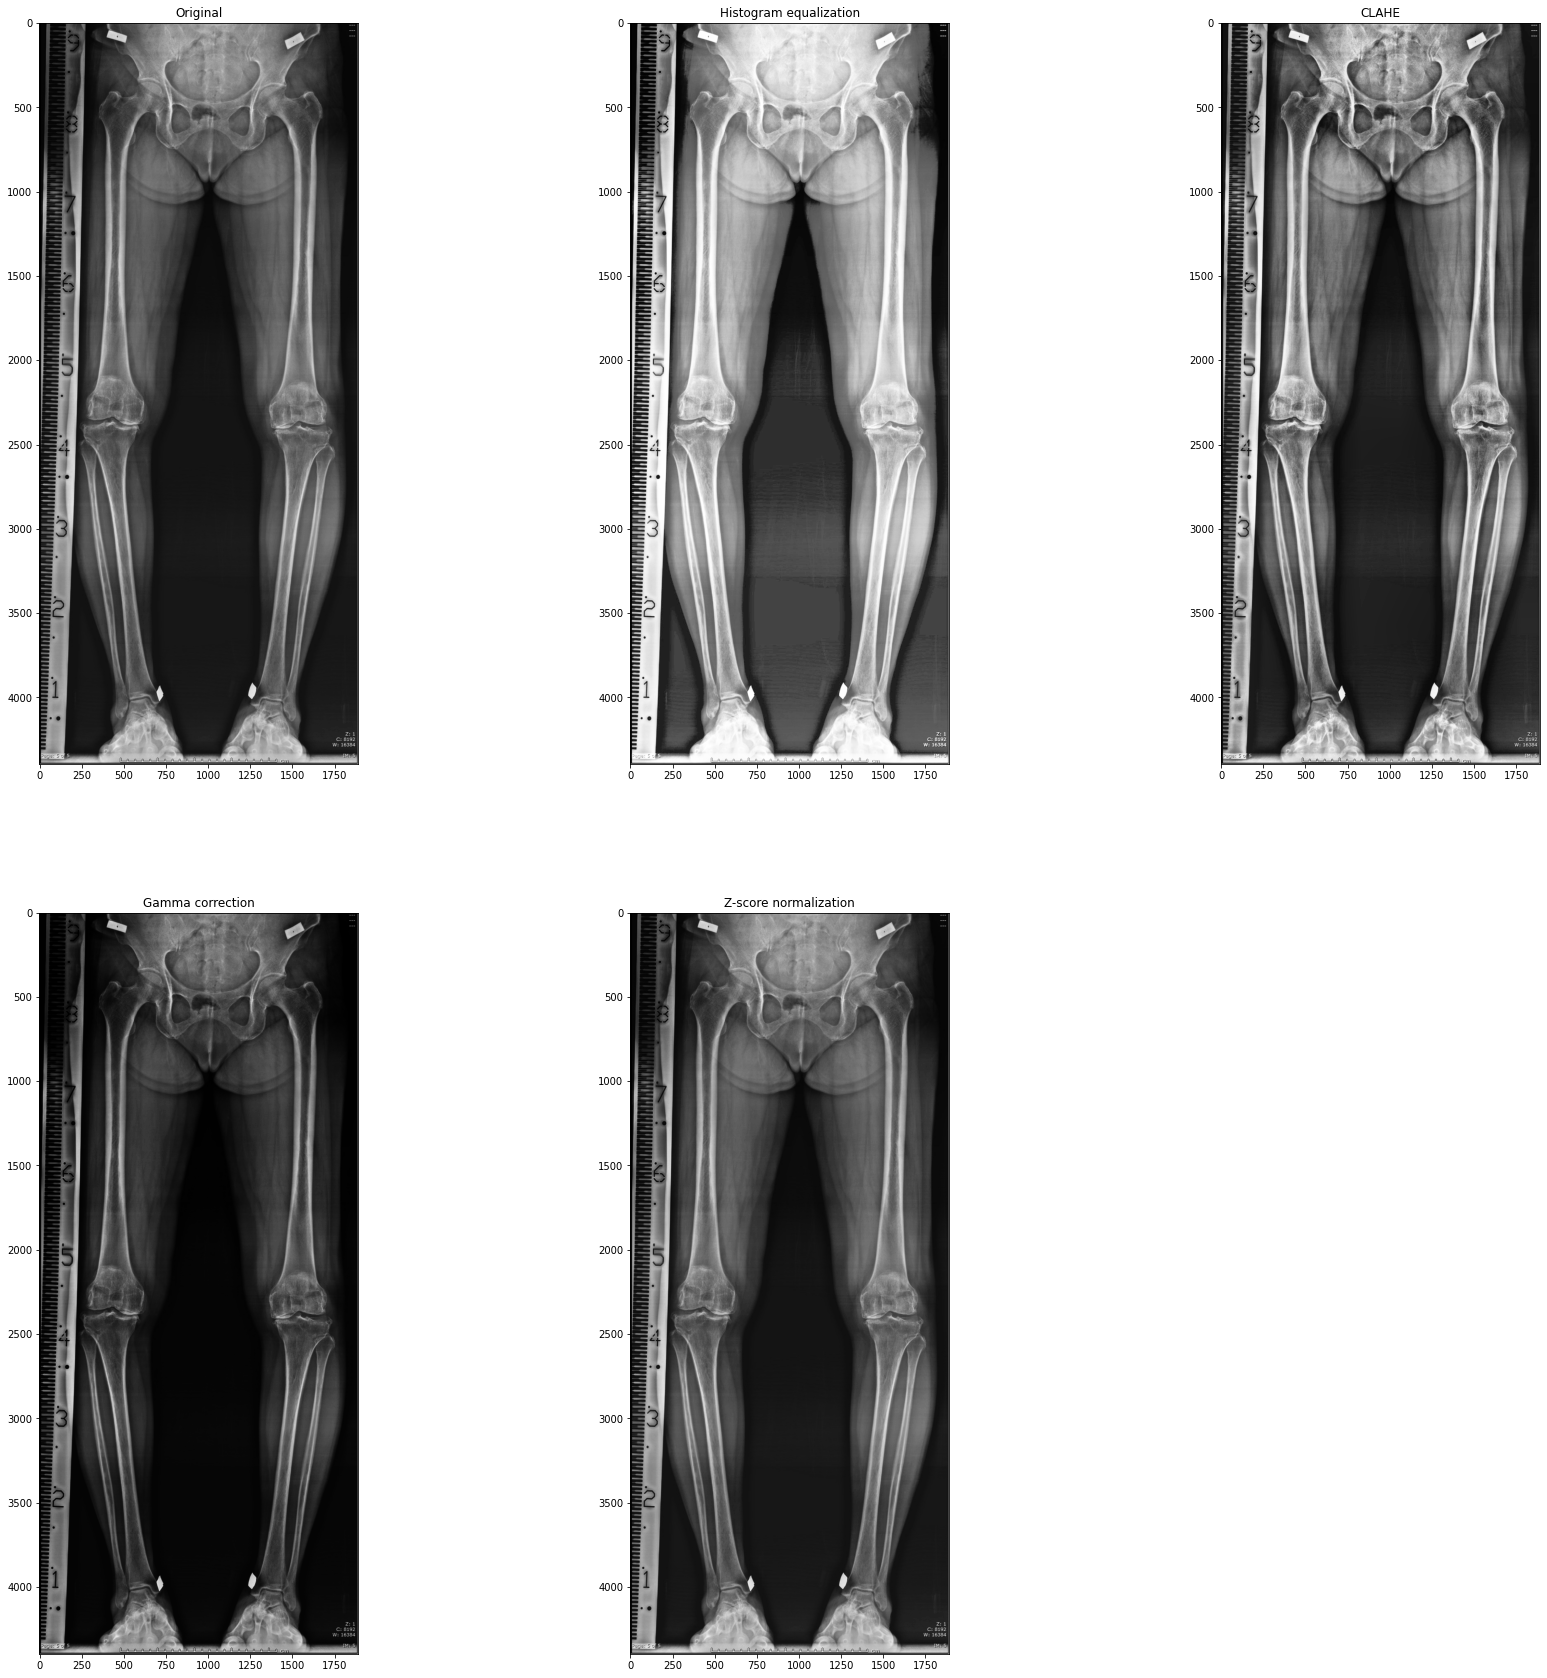

In [62]:
img = cv2.imread('../test_light.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histogram equalization
equalized_img = cv2.equalizeHist(img)

# Contrast Limited Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(img)

# Gamma correction
gamma = 1.5
gamma_corrected = np.uint8(cv2.pow(img/255.0, gamma) * 255.0)

# Z-score normalization
mean, std = cv2.meanStdDev(img)
z_score_normalized = (img - mean) / std

plt.figure(figsize=(30,30))
plt.subplot(2,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(equalized_img, cmap="gray")
plt.title("Histogram equalization")
plt.subplot(2,3,3)
plt.imshow(clahe_img, cmap="gray")
plt.title("CLAHE")
plt.subplot(2,3,4)
plt.imshow(gamma_corrected, cmap="gray")
plt.title("Gamma correction")
plt.subplot(2,3,5)
plt.title("Z-score normalization")
plt.imshow(z_score_normalized, cmap="gray")

# Template Matching
Proposed Methods
- Multiple templates -> Different Bone Density & Perspective
- Scaling -> Scale Invariance
- Rotation -> Rotation Invariance

What to try:
- preprocessed template
- cv2 Matching params tuning

What I have tried and didn't work
- Hough Line detection for detecting 2 leg bones (Tibia and Femur): too high variance in bone shape
- Otsu's thresholding and detecting bone contour

Further Improvement
- Highly recommended to try implementing ML object detection model when data is ready.

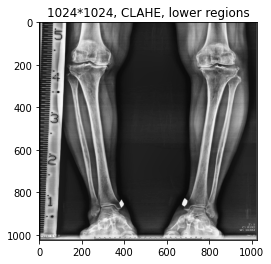

In [2]:
def preprocess(img, resized=(1024,1024), region="low"):
    # Grayscale Input

    # Normalization: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Region of Interest
    h,w = img.shape[:2]
    if region=="low":
        img = img[w:]
    elif region=="mid":
        img = img[(h-w)//2:(h+w)//2]
    elif region=="high":
        img = img[:w]

    # Resized
    img = cv2.resize(img, dsize=resized)

    return img

img_path = "../test_light.jpg"
# img_path = "../test_light.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_prep = preprocess(img, region="low")

plt.imshow(img_prep, cmap="gray")
plt.title("1024*1024, CLAHE, lower regions")
plt.show()

In [3]:
from peakdetect import peakdetect

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def peakDetection(y, p_threshold=-1, v_threshold=-1):
  [peaks_raw, valleys_raw] = peakdetect(y, lookahead=256)
  peaks = []
  valleys=[]

  for peak in peaks_raw:
    if p_threshold == -1 or peak[1] > p_threshold:
      peaks.append(peak[0])

  for valley in valleys_raw:
    if v_threshold == -1 or valley[1] < v_threshold:
      valleys.append(valley[0])
  
  return peaks, valleys

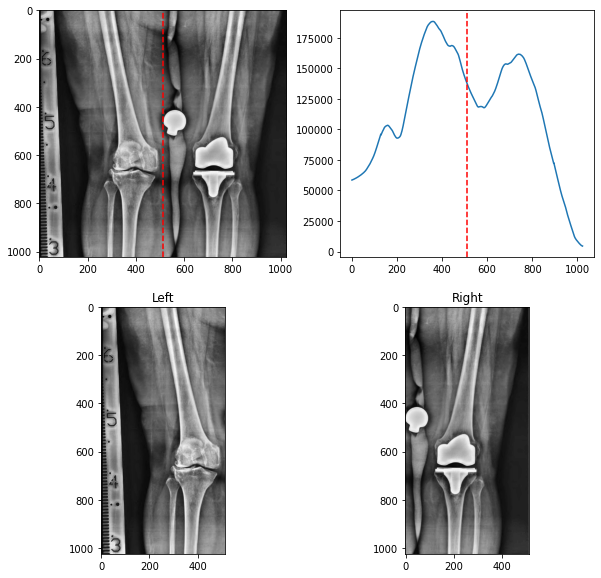

In [62]:
def getBreakpoint(img):
    _, img_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hist = np.sum(img_thresh, axis=0)

    hist = smooth(hist, box_pts=256)
    peaks, valleys = peakDetection(hist)

    if len(valleys)==1:
        breakpoint_ = valleys[0]
    elif len(valleys)==0:
        breakpoint_ = len(hist)//2
    else:
        mid = len(hist)/2
        id_ = np.argmin([abs(v-512) for v in valleys])
        breakpoint_ = valleys[id_]
    
    return breakpoint_

# Viz
img_path = "../dev/035.jpg"
# img_path = "../test_light.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_prep = preprocess(img, region="mid")
_, img_thresh = cv2.threshold(img_prep, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
hist = np.sum(img_thresh, axis=0)

hist = smooth(hist, box_pts=256)
peaks, valleys = peakDetection(hist)

if len(valleys)==1:
    breakpoint_ = valleys[0]
elif len(valleys)==0:
    breakpoint_ = 512
else:
    mid = len(hist)/2
    id_ = np.argmin([abs(v-512) for v in valleys])
    breakpoint_ = valleys[id_]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img_prep, cmap="gray")
plt.axvline(breakpoint_, color='r', linestyle='--')

plt.subplot(2,2,2)
plt.plot(hist)
plt.axvline(breakpoint_, color='r', linestyle='--')

plt.subplot(2,2,3)
plt.imshow(img_prep[:,:breakpoint_], cmap="gray")
plt.title("Left")

plt.subplot(2,2,4)
plt.imshow(img_prep[:,breakpoint_:], cmap="gray")
plt.title("Right")

plt.show()

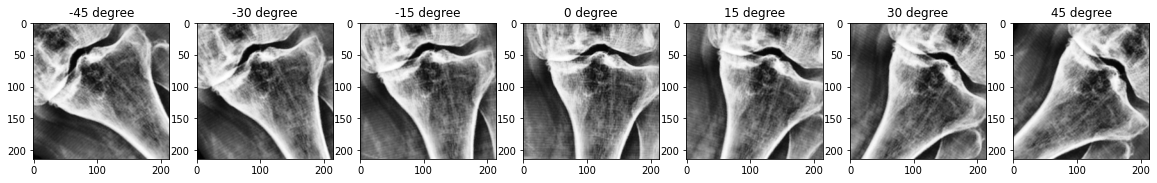

In [77]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

img = cv2.imread('templates/template_talus_right_2.jpg')
# img = cv2.imread('templates/template_knee_right.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
i=1
plt.figure(figsize=(20,_))
for angle in np.arange(-45, 46, 15): # [-45, -30, -15, 0, 15, 30, 45]
    rotated = rotate_image(img, angle)

    h,w = rotated.shape[:2]
    plt.subplot(1,7,i)
    i+=1
    plt.imshow(rotated[h//4:-h//4,w//4:-w//4], cmap="gray")
    plt.title(f"{angle} degree")

In [78]:
def templateMatcher(img, template, scales=np.arange(0.8,1.21,0.1), angles=np.arange(-45,46,15)):
    # Initialize best match values
    best_scale = 1
    best_loc = None
    best_angle = None
    best_score = -np.inf
        
    # Iterate over rotation
    for angle in angles:
        rotated = rotate_image(template, angle)
        h,w = rotated.shape[:2]
        rotated = rotated[h//4:-h//4,w//4:-w//4]
        # res = cv2.matchTemplate(img, rotated, cv2.TM_CCOEFF_NORMED)

        # Iterate over scales
        for scale in scales:         
            # Resize template
            resized_template = cv2.resize(rotated, None, fx=scale, fy=scale)

            res = cv2.matchTemplate(img,resized_template,cv2.TM_CCOEFF_NORMED)

            # Find location of best match for current scale
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            # Update best match values if current scale has better match
            if max_val > best_score:
                best_scale = scale
                best_angle = angle
                best_loc = max_loc
                best_score = max_val

        w, h = (np.array(rotated.shape[1::-1]) * best_scale).astype(int)
        cv2.rectangle(img, best_loc, (best_loc[0] + w, best_loc[1] + h), (255, 255, 255), 2)

    # # Draw rectangle around best match at best scale
    # cv2.rectangle(img, best_loc, (best_loc[0] + w, best_loc[1] + h), (255, 255, 255), 2)

    # plt.figure(figsize=(5,5))
    # plt.imshow(img, cmap="gray")
    # plt.title(img_path + f': {best_temp}/ s{best_scale:.2f}/ a{best_angle}/ val={max_val:.2f}')
    # plt.show()

    return best_loc[0], best_loc[1], w, h

In [1]:
# Set scales and angles for template
min_scale = 0.9
max_scale = 1.11
scale_step = 0.1
min_rot = -15
max_rot = 46
rot_step = 15

template_talus_left_path = 'templates/template_knee_left.jpg'
template_talus_right_path = 'templates/template_knee_right.jpg'
img_path = "../test_dark.jpg"

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_prep = preprocess(img, region="mid")
img_prep = img_prep

bp = getBreakpoint(img_prep)

# Left Talus
template = cv2.imread(template_talus_left_path, cv2.IMREAD_GRAYSCALE)
x, y, w, h = templateMatcher(img_prep[:,:bp],
                             template,
                             scales=np.arange(min_scale, max_scale, scale_step),
                             angles=np.arange(-45, 16, rot_step),
                             )
cv2.rectangle(img_prep, (x,y), (x+w,y+h), (255, 255, 255), 20)

# Right Talus
template = cv2.imread(template_talus_right_path, cv2.IMREAD_GRAYSCALE)
x, y, w, h = templateMatcher(img_prep[:,bp:],
                             template,
                             scales=np.arange(min_scale, max_scale, scale_step),
                             angles=np.arange(-15, 46, rot_step),
                             )
x += bp
cv2.rectangle(img_prep, (x,y), (x+w,y+h), (255, 255, 255), 20)

plt.figure(figsize=(5,5))
plt.imshow(img_prep, cmap="gray")
plt.show()

NameError: name 'cv2' is not defined

In [ ]:
# validate w/ dev set
dev_path = "../dev/"
for img_path in os.listdir(dev_path)[0:30]:
    if img_path.endswith('.jpg'):
        # Set scales and angles for template
        min_scale = 0.8
        max_scale = 1.21
        scale_step = 0.1
        min_rot = -45
        max_rot = 46
        rot_step = 15

        template_talus_left_path = 'templates/template_talus_left.jpg'
        template_talus_right_path = 'templates/template_talus_right.jpg'

        img = cv2.imread(dev_path+img_path)
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        resized = (1024,1024)
        img_prep = preprocess(img_gray, resized)

        bp = getBreakpoint(img_prep)

        # Left Talus
        template = cv2.imread(template_talus_left_path, cv2.IMREAD_GRAYSCALE)
        x, y, w, h = templateMatcher(img_prep[:,:bp],
                                    template,
                                    scales=np.arange(min_scale, max_scale, scale_step),
                                    angles=np.arange(min_rot, max_rot, rot_step),
                                    )
        [x,y,w,h] = np.array([x,y,w,h]) * img_gray.shape[1] // resized[0] 
        y += img_gray.shape[0]-img_gray.shape[1]
        cv2.rectangle(img_gray, (x,y), (x+w,y+h), (255, 255, 255), 20)

        # Right Talus
        template = cv2.imread(template_talus_right_path, cv2.IMREAD_GRAYSCALE)
        x, y, w, h = templateMatcher(img_prep[:,bp:],
                                    template,
                                    scales=np.arange(min_scale, max_scale, scale_step),
                                    angles=np.arange(min_rot, max_rot, rot_step),
                                    )
        x += bp
        [x,y,w,h] = np.array([x,y,w,h]) * img_gray.shape[1] // resized[0] 
        y += img_gray.shape[0]- img_gray.shape[1]
        cv2.rectangle(img_gray, (x,y), (x+w,y+h), (255, 255, 255), 20)

        plt.figure(figsize=(5,5))
        plt.imshow(img_gray, cmap="gray")
        plt.title(img_path)
        plt.show()

In [ ]:
dev_path = "../dev/"
for img_path in os.listdir(dev_path)[30:]:
    if img_path.endswith('.jpg'):
        img = cv2.imread(dev_path+img_path)
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        resized = (1024,1024)
        img_prep = preprocess(img_gray, resized, region="mid")
        bp = getBreakpoint(img_prep)
        
        plt.imshow(img_prep, cmap="gray")
        plt.axvline(breakpoint_, color='r', linestyle='--')

        plt.title(img_path)
        plt.show()

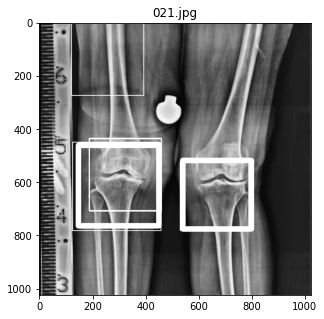

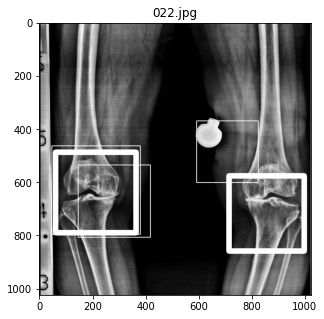

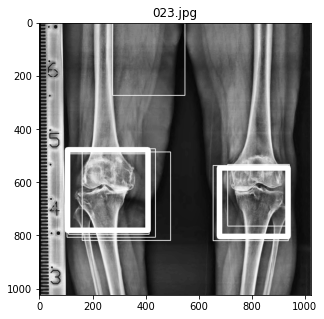

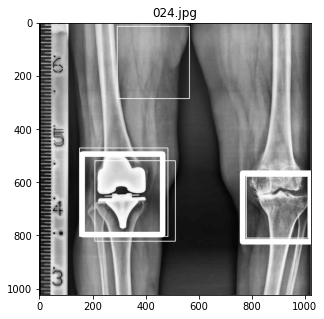

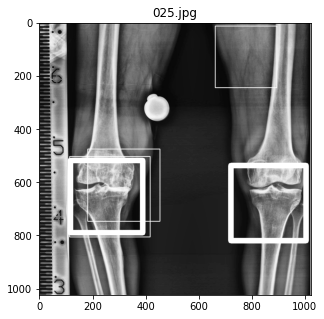

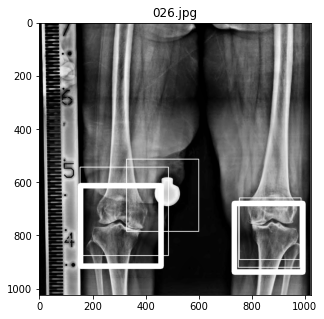

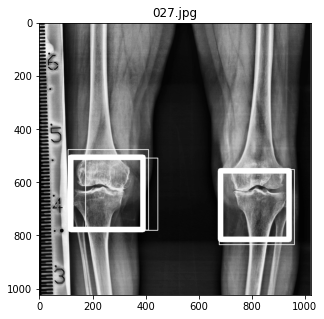

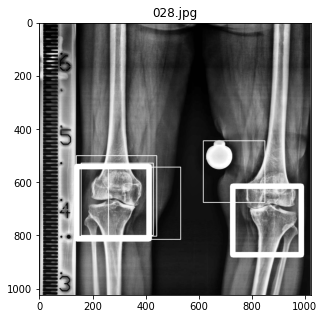

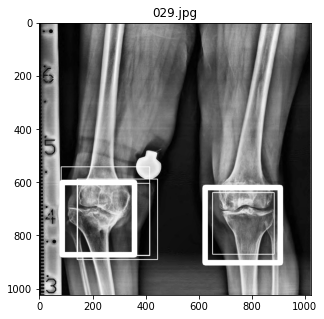

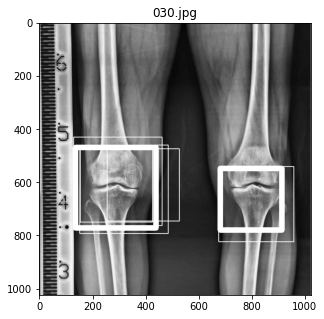

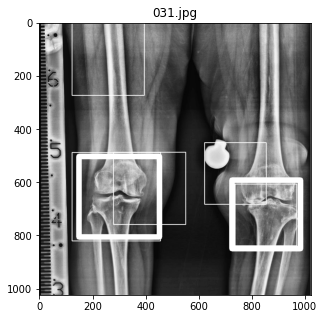

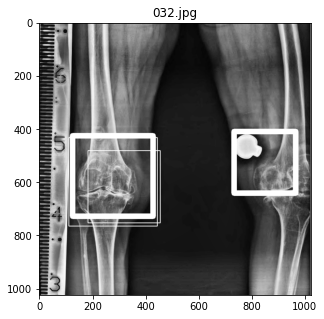

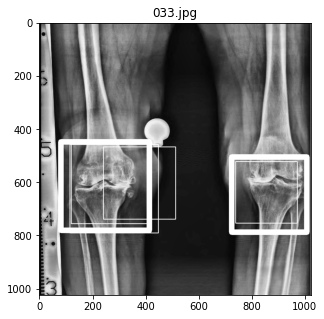

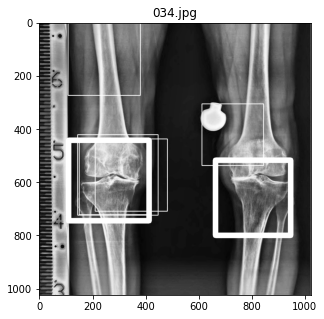

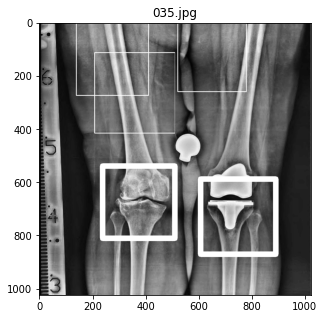

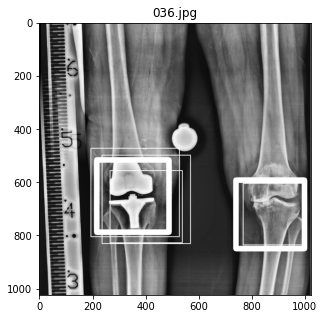

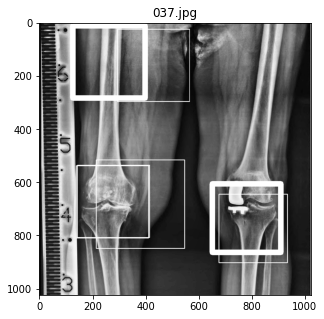

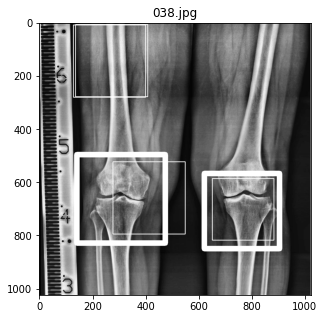

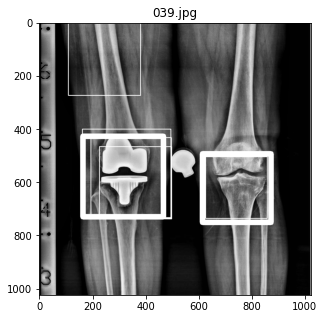

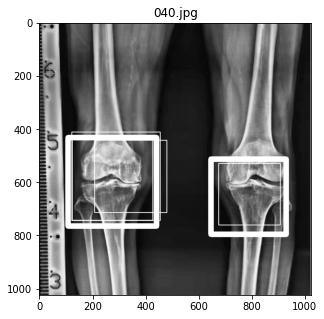

In [72]:
# validate w/ dev set
dev_path = "../dev/"
for img_path in os.listdir(dev_path)[20:40]:
    if img_path.endswith('.jpg'):
        # Set scales and angles for template
        min_scale = 0.9
        max_scale = 1.11
        scale_step = 0.1
        min_rot = 0
        max_rot = 46
        rot_step = 10

        template_talus_left_path = 'templates/template_knee_left.jpg'
        template_talus_right_path = 'templates/template_knee_right.jpg'

        img = cv2.imread(dev_path+img_path)
        img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        resized = (1024,1024)
        img_prep = preprocess(img_gray, resized, region="mid")

        bp = getBreakpoint(img_prep)

        # Left Knee
        template = cv2.imread(template_talus_left_path, cv2.IMREAD_GRAYSCALE)
        x, y, w, h = templateMatcher(img_prep[:,:bp],
                                    template,
                                    scales=np.arange(min_scale, max_scale, scale_step),
                                    angles=np.arange(-45, 16, rot_step),
                                    )
        # [x,y,w,h] = np.array([x,y,w,h]) * img_gray.shape[1] // resized[0] 
        # y += img_gray.shape[0]-img_gray.shape[1]
        cv2.rectangle(img_prep, (x,y), (x+w,y+h), (255, 255, 255), 20)

        # Right Talus
        template = cv2.imread(template_talus_right_path, cv2.IMREAD_GRAYSCALE)
        x, y, w, h = templateMatcher(img_prep[:,bp:],
                                    template,
                                    scales=np.arange(min_scale, max_scale, scale_step),
                                    angles=np.arange(-15, 45, rot_step),
                                    )
        x += bp
        # [x,y,w,h] = np.array([x,y,w,h]) * img_gray.shape[1] // resized[0] 
        # y += img_gray.shape[0]- img_gray.shape[1]
        cv2.rectangle(img_prep, (x,y), (x+w,y+h), (255, 255, 255), 20)

        plt.figure(figsize=(5,5))
        plt.imshow(img_prep, cmap="gray")
        plt.title(img_path)
        plt.show()

# ทด

(578, 3704)


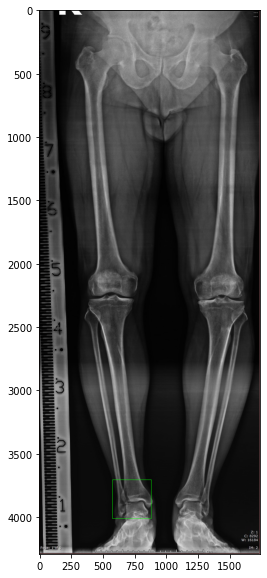

In [71]:
img_path = "../dev/001.jpg"
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE)

# Set minimum and maximum scales for template
min_scale = 0.2
max_scale = 2.0

# Set step size for scales
scale_step = 0.1

# Initialize best match values
best_scale = 0
best_loc = None
best_score = -np.inf

# Iterate over scales
for scale in np.arange(min_scale, max_scale, scale_step):
    # Resize template
    resized_template = cv2.resize(template, None, fx=scale, fy=scale)
    w, h = resized_template.shape[::-1]
    res = cv2.matchTemplate(img_gray,resized_template,cv2.TM_CCOEFF_NORMED)

    threshold = 0.8
    loc = np.where( res >= threshold)
    for pt in zip(*loc[::-1]):
        cv2.rectangle(img_RGB, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    # Find location of best match for current scale
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Update best match values if current scale has better match
    if max_val > best_score:
        best_scale = scale
        best_loc = max_loc
        best_score = max_val

w, h = (np.array(template.shape[1::-1]) * best_scale).astype(int)

# Draw rectangle around best match at best scale
print(best_loc)
cv2.rectangle(img_RGB, best_loc, (best_loc[0] + w, best_loc[1] + h), (0, 255, 0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img_RGB)

In [ ]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, -angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

img = cv2.imread('templates/template_01.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# rotated_img = rotate_image(img, 45)
for angle in np.arange(0, 90, 30):
    rotated = rotate_image(img, angle)
    plt.imshow(rotated, cmap="gray")
    plt.show()

In [ ]:
templates_folder = 'templates/'
for template_name in os.listdir(templates_folder)[1:3]:
    # Load the template image
    template = cv2.imread(os.path.join(templates_folder, template_name), cv2.IMREAD_GRAYSCALE)

    # Iterate over rotation
    for angle in np.arange(0, 91, 30):
        rotated = rotate_image(template, angle)

        # Iterate over scales
        for scale in np.arange(0.5, 1.51, 0.5):         
            # Resize template
            resized = cv2.resize(rotated, None, fx=scale, fy=scale)
            plt.imshow(resized, cmap="gray")
            plt.show()

In [84]:
templates_folder = 'templates/'
def talusDetector(img_path):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    img = img[3*h//4:,:]
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Set minimum and maximum scales for template
    min_scale = 0.5
    max_scale = 1.5
    scale_step = 0.1
    min_rot = -60
    max_rot = 61
    rot_step = 15

    # Initialize best match values
    best_scale = 0
    best_loc = None
    best_angle = None
    best_score = -np.inf
    best_temp = ""

    # Iterate over multiple templates
    for template_name in os.listdir(templates_folder)[1:3]:
        # Load the template image
        template = cv2.imread(os.path.join(templates_folder, template_name), cv2.IMREAD_GRAYSCALE)

        # Iterate over rotation
        for angle in np.arange(min_rot, max_rot, rot_step):
            rotated = rotate_image(template, angle)

            # Iterate over scales
            for scale in np.arange(min_scale, max_scale, scale_step):         
                # Resize template
                resized_template = cv2.resize(rotated, None, fx=scale, fy=scale)

                res = cv2.matchTemplate(img_gray,resized_template,cv2.TM_CCOEFF_NORMED)

                # threshold = 0.8
                # loc = np.where( res >= threshold)
                # w, h = resized_template.shape[::-1]
                # for pt in zip(*loc[::-1]):
                #     cv2.rectangle(img_RGB, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

                # Find location of best match for current scale
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                # Update best match values if current scale has better match
                if max_val > best_score:
                    best_scale = scale
                    best_angle = angle
                    best_loc = max_loc
                    best_score = max_val
                    best_temp = template_name

        w, h = (np.array(template.shape[1::-1]) * best_scale).astype(int)

    # Draw rectangle around best match at best scale
    # print(best_loc)
    cv2.rectangle(img_RGB, best_loc, (best_loc[0] + w, best_loc[1] + h), (0, 255, 0), 2)

    plt.figure(figsize=(20,10))
    plt.imshow(img_RGB)
    plt.title(img_path + f': {best_temp}/ s{best_scale:.2f}/ a{best_angle}/ val={max_val:.2f}')
    plt.show()

In [ ]:
res = cv2.matchTemplate(img_gray,resized_template,cv2.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# Iterate through dev set

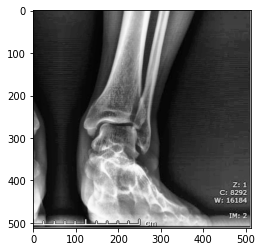

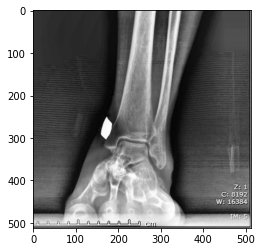

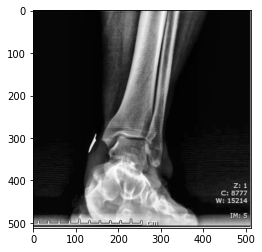

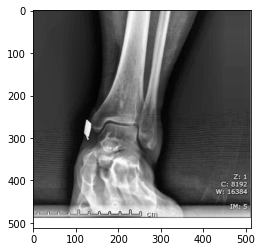

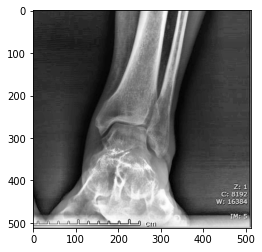

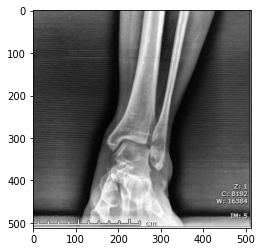

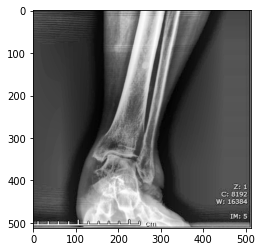

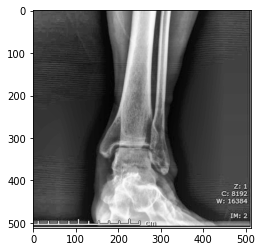

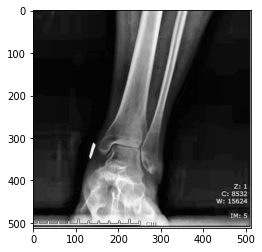

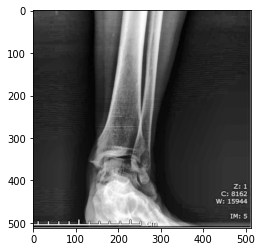

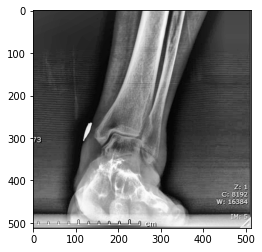

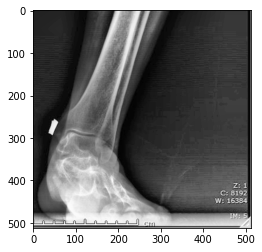

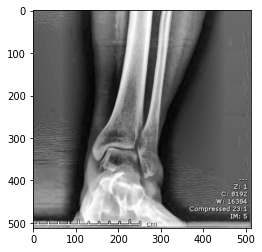

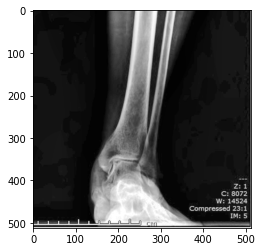

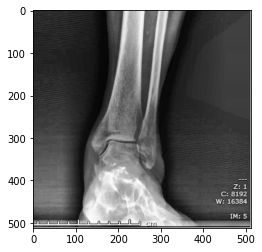

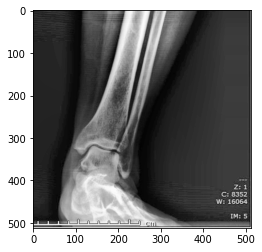

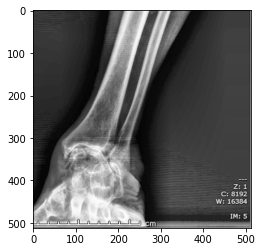

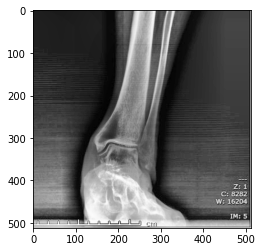

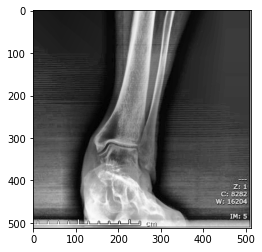

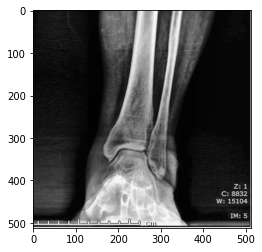

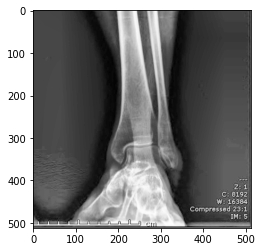

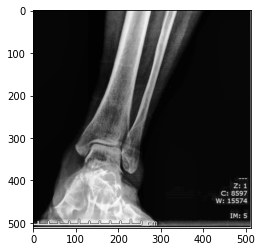

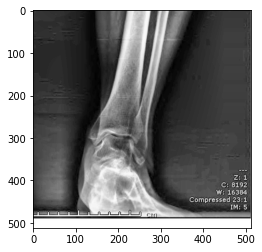

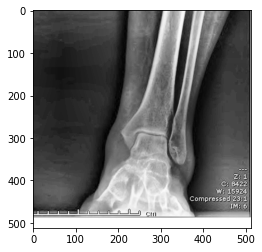

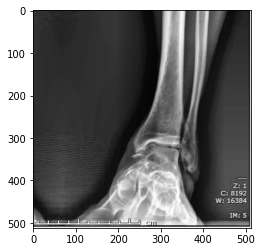

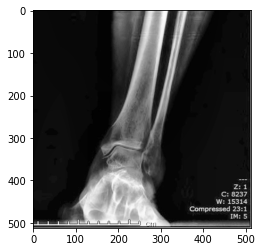

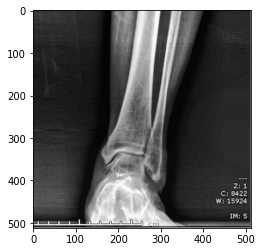

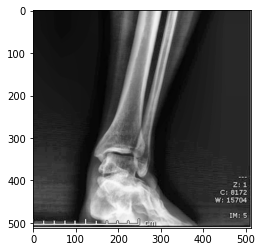

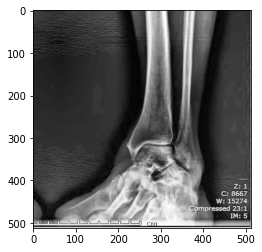

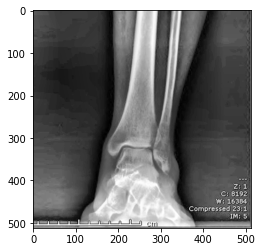

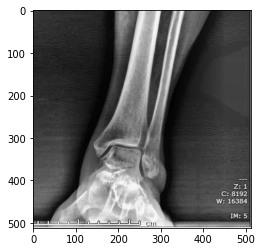

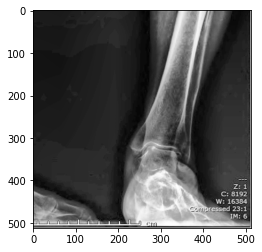

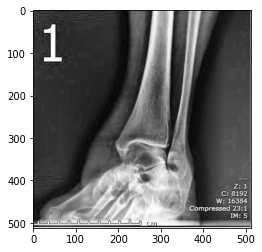

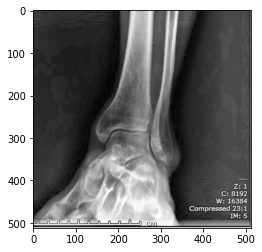

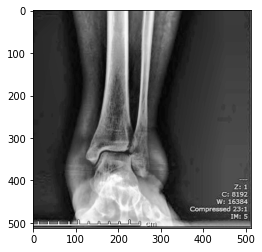

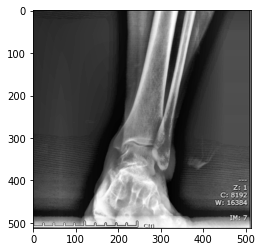

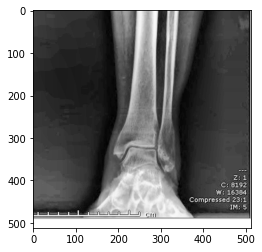

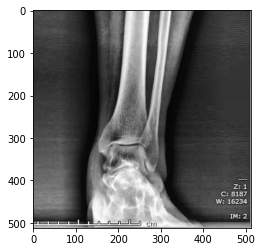

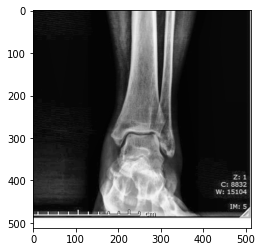

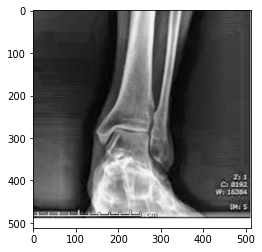

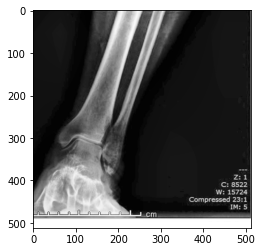

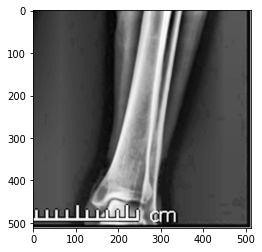

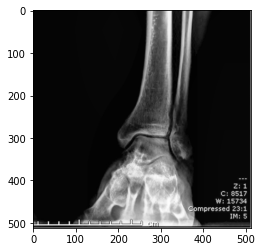

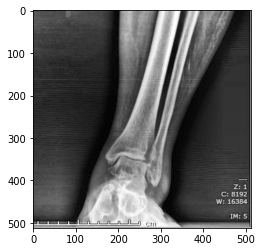

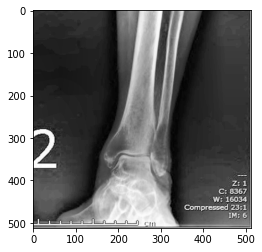

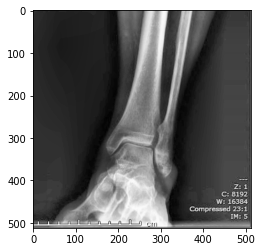

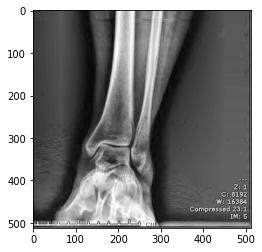

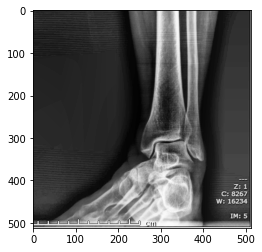

In [75]:
# validate w/ dev set
dev_path = "../dev_norm/"
for img_path in os.listdir(dev_path):
    if img_path.endswith('.jpg'):
        img = cv2.imread(dev_path + img_path)
        img_prep = preprocess(img)
        plt.imshow(img_prep[512:,512:], cmap="gray")
        plt.show()
        # talusDetector(dev_path + img_path)

Here are some techniques that you can use to improve template matching:

Use a larger template image: A larger template image will capture more detail and features of the object you want to match, and thus increase the chances of finding a good match.

Use multiple templates: If the object you want to match has different variations, such as different orientations or lighting conditions, you can create multiple templates for each variation and match against all of them.

Preprocess the template and source images: Preprocessing techniques such as edge detection, smoothing, and thresholding can help to remove noise and enhance the features of the images, making it easier to find a good match.

Use a better matching method: Different matching methods, such as normalized cross-correlation, correlation coefficient, and mean squared error, can produce different results depending on the type of images and the degree of similarity. Experimenting with different methods and parameters can help you find the best one for your application.

Use a region of interest (ROI): If you know the approximate location of the object you want to match in the source image, you can crop a smaller region around it and perform template matching only on that region, which can improve the speed and accuracy of the matching.

Apply scale and rotation invariance: If the object you want to match can appear at different scales or orientations, you can apply techniques such as scale normalization or rotation normalization to make the matching more robust.

Use machine learning-based techniques: Advanced techniques such as deep learning-based object detection can be used to automatically learn the features of the object you want to match and improve the accuracy and speed of the matching process.

By applying one or more of these techniques, you can significantly improve the accuracy and robustness of template matching for your application.

# Save dev set

In [ ]:
# dev_path = "../dev/"

# for img_path in os.listdir(dev_path):
#     if img_path.endswith('.jpg'):
#         img = cv2.imread(dev_path+img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#         # Contrast Limited Adaptive Histogram Equalization (CLAHE)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         clahe_img = clahe.apply(img)
#         cv2.imwrite("../dev_norm/"+img_path, clahe_img)

In [327]:
img_fol = "../dev_norm/"
dest = "../dev_knee_norm_gray_1024/"
for img_name in os.listdir(img_fol):
    img_path = img_fol+img_name
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_prep = preprocess(img_gray, region="mid")
    cv2.imwrite(dest+img_name, img_prep)